In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

In [2]:
motor_df = pd.read_csv("motor_window_features_10Hz_KNN_ready.csv")
secondary_df = pd.read_csv("secondary_window_features_10Hz_KNN_ready.csv")

print("Motor windows:", motor_df.shape)
print("Secondary windows:", secondary_df.shape)

secondary_df.head(5)

Motor windows: (535, 40)
Secondary windows: (327, 40)


,t_10hz_mean,timestamp_mean,speed_kmh_mean,lat_mean,lon_mean,alt_mean,vert_acc_mean,horiz_acc_mean,course_mean,difcourse_mean,...,gps_speed_mean,max_speed_mean,speed_rel_mean,num_lanes_mean,lat_osm_mean,lon_osm_mean,osm_delay_mean,gps_speed_osm_mean,speed_ratio_mean,label
0,1199.5,119.95,113.150138,40.529548,-3.441663,635.907523,5.553246,5.245833,291.986450,2.299453,...,113.332708,90.740665,1.130833,1.962154,40.529483,-3.440870,1.623084,112.821897,1.346173,0
1,1459.5,145.95,114.150083,40.534167,-3.446960,646.916125,5.488333,5.245833,302.150958,2.292566,...,114.161667,86.033333,1.130833,1.834583,40.533707,-3.445721,1.942002,114.040458,1.481055,0
2,1719.5,171.95,113.640000,40.537531,-3.454224,656.628042,5.624167,5.245833,300.947750,2.273659,...,113.642333,85.158333,1.089167,1.843750,40.536876,-3.452646,2.135032,112.815292,1.486653,0
3,1979.5,197.95,113.905958,40.540639,-3.461621,668.014375,5.746667,5.245833,295.752417,2.211698,...,113.916542,84.652917,1.078333,1.850833,40.540000,-3.459575,2.760698,113.192542,0.810597,0
4,2239.5,223.95,114.565333,40.543104,-3.469355,680.536583,5.824167,5.245833,293.369667,2.384398,...,114.602958,84.732083,1.094167,1.874167,40.542584,-3.466453,3.569630,113.995958,0.816965,0


We isolate normal driving windows to use them as the reference baseline for distance calculations.

In [3]:
motor_normal_df = motor_df[motor_df["label"] == 2]
secondary_normal_df = secondary_df[secondary_df["label"] == 2]

print("Motor NORMAL:", motor_normal_df.shape)
print("Secondary NORMAL:", secondary_normal_df.shape)

Motor NORMAL: (170, 40)
Secondary NORMAL: (110, 40)


We define which numeric driving features are used to measure similarity and distance.

In [4]:
feature_cols = (motor_normal_df.select_dtypes(include=["int64", "float64"]).drop(columns=["label"]).columns.tolist())
print("Number of features:", len(feature_cols))
feature_cols[:5]

Number of features: 39


['t_10hz_mean', 'timestamp_mean', 'speed_kmh_mean', 'lat_mean', 'lon_mean']

Scaling = teaching the system what “normal” looks like, feature by feature.

In [5]:
motor_scaler = StandardScaler()
secondary_scaler = StandardScaler()

motor_normal_scaled = motor_scaler.fit_transform(motor_normal_df[feature_cols])
secondary_normal_scaled = secondary_scaler.fit_transform(secondary_normal_df[feature_cols])

print("Scalers fitted for both road types")

Scalers fitted for both road types


In [6]:
motor_knn = NearestNeighbors(n_neighbors=5, metric="euclidean")
secondary_knn = NearestNeighbors(n_neighbors=5, metric="euclidean")

motor_knn.fit(motor_normal_scaled)
secondary_knn.fit(secondary_normal_scaled)

print("KNN models trained for motor & secondary")

KNN models trained for motor & secondary


In [7]:
def knn_distance(row, scaler, knn, feature_cols):
    row_df = row[feature_cols].to_frame().T
    row_scaled = scaler.transform(row_df)
    distances, _ = knn.kneighbors(row_scaled)
    return distances.mean()

Apply distance to all windows (per road)

In [8]:
motor_df["knn_distance"] = motor_df.apply(
    lambda row: knn_distance(row, motor_scaler, motor_knn, feature_cols),
    axis=1
)

In [9]:
secondary_df["knn_distance"] = secondary_df.apply(
    lambda row: knn_distance(row, secondary_scaler, secondary_knn, feature_cols),
    axis=1
)

In [10]:
print("Motor mean distance by label")
print(motor_df.groupby("label")["knn_distance"].mean())

print("\nSecondary mean distance by label")
print(secondary_df.groupby("label")["knn_distance"].mean())

Motor mean distance by label
label
0     9.497777
1    18.118607
2     1.553104
Name: knn_distance, dtype: float64

Secondary mean distance by label
label
0    11.034117
1    11.872582
2     2.107862
Name: knn_distance, dtype: float64


In [11]:
# Motor threshold (based on NORMAL only)
motor_normal_dist = motor_df[motor_df["label"] == 2]["knn_distance"]
motor_threshold = motor_normal_dist.mean() + 2 * motor_normal_dist.std()

# Secondary threshold
secondary_normal_dist = secondary_df[secondary_df["label"] == 2]["knn_distance"]
secondary_threshold = secondary_normal_dist.mean() + 2 * secondary_normal_dist.std()

motor_threshold, secondary_threshold

(np.float64(3.1310174974759786), np.float64(3.3189033502903285))

In [14]:
motor_abnormal = motor_df[motor_df["knn_distance"] > motor_threshold].copy()
secondary_abnormal = secondary_df[secondary_df["knn_distance"] > secondary_threshold].copy()

motor_abnormal.shape, secondary_abnormal.shape

((344, 41), (220, 41))

These are just quick checks to see if everything is okay

In [15]:
motor_abnormal["label"].value_counts()

label
1    208
0    127
2      9
Name: count, dtype: int64

In [16]:
motor_df.groupby("label")["knn_distance"].describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
0,154.0,9.497777,15.827434,1.586122,3.561238,4.957280,7.296057,96.049859
1,211.0,18.118607,30.679579,2.372704,5.765132,7.799655,10.381865,128.370839
2,170.0,1.553104,0.788957,0.750604,1.020095,1.231511,1.807330,5.177361


In [17]:
motor_df.shape, motor_abnormal.shape
len(motor_abnormal) / len(motor_df)

0.6429906542056075

Preparing data for clustering

In [18]:
motor_X = motor_scaler.transform(motor_abnormal[feature_cols])
secondary_X = secondary_scaler.transform(secondary_abnormal[feature_cols])

In [22]:
from sklearn.cluster import KMeans

motor_kmeans = KMeans(
    n_clusters=3,
    random_state=42,
    n_init=10
)

motor_clusters = motor_kmeans.fit_predict(motor_X)

motor_abnormal["cluster"] = motor_clusters
motor_abnormal["cluster"].value_counts()

cluster
0    309
1     19
2     16
Name: count, dtype: int64

In [23]:
secondary_kmeans = KMeans(
    n_clusters=3,
    random_state=42,
    n_init=10
)

secondary_clusters = secondary_kmeans.fit_predict(secondary_X)

secondary_abnormal["cluster"] = secondary_clusters
secondary_abnormal["cluster"].value_counts()

cluster
2    101
0     91
1     28
Name: count, dtype: int64

Naming the clusters, we decide this through seeing which features are the highest in each cluster (for each type of aggressive or drowsy behaving there is features that explain the type of this action, example: max_speed --> overspeeding and so on...

In [24]:
# Look at average feature values per cluster (motor)
motor_cluster_summary = (
    motor_abnormal
    .groupby("cluster")[feature_cols]
    .mean()
)

motor_cluster_summary

,t_10hz_mean,timestamp_mean,speed_kmh_mean,lat_mean,lon_mean,alt_mean,vert_acc_mean,horiz_acc_mean,course_mean,difcourse_mean,...,num_vehicles_mean,gps_speed_mean,max_speed_mean,speed_rel_mean,num_lanes_mean,lat_osm_mean,lon_osm_mean,osm_delay_mean,gps_speed_osm_mean,speed_ratio_mean
cluster,,,,,,,,,,,,,,,,,,,,,
0,4943.781077,494.378108,98.078137,40.479547,-3.422619,591.817552,3.962128,7.234170,149.380020,1.666064,...,1.464029,98.926379,111.024513,1.016808,2.700698,40.274563,-3.406974,2.054703,98.820019,-1.151836
1,2581.213750,258.121375,89.173330,40.481543,-3.411545,592.336465,5.204803,15.444715,232.458606,1.225628,...,1.501601,91.594436,111.121798,1.042390,2.802544,40.481324,-3.412249,2.727827,91.572823,-3.403812
2,3815.537630,381.553763,96.778714,40.479824,-3.424510,594.022680,4.148385,20.598568,188.919003,1.786037,...,1.540990,100.289352,112.128229,1.025495,2.732708,40.478492,-3.426966,1.908712,100.658648,-0.167782


In [25]:
# Look at average feature values per cluster (secondary)
secondary_cluster_summary = (
    secondary_abnormal
    .groupby("cluster")[feature_cols]
    .mean()
)

secondary_cluster_summary

,t_10hz_mean,timestamp_mean,speed_kmh_mean,lat_mean,lon_mean,alt_mean,vert_acc_mean,horiz_acc_mean,course_mean,difcourse_mean,...,num_vehicles_mean,gps_speed_mean,max_speed_mean,speed_rel_mean,num_lanes_mean,lat_osm_mean,lon_osm_mean,osm_delay_mean,gps_speed_osm_mean,speed_ratio_mean
cluster,,,,,,,,,,,,,,,,,,,,,
0,2844.301447,284.430145,93.170407,40.555438,-3.494769,659.168312,4.250068,8.945432,265.030969,2.493731,...,0.640842,94.234898,88.810014,1.145512,1.972784,40.553749,-3.492427,2.402207,93.841304,0.854620
1,3859.088571,385.908857,87.618605,40.560254,-3.506600,685.903168,3.609613,6.685565,248.214608,2.674874,...,0.796190,87.878984,79.728897,1.080089,1.674745,40.558994,-3.501485,17.869709,87.767247,-8.421191
2,3397.068020,339.706802,88.682899,40.547160,-3.476965,665.957520,3.911677,8.245440,129.114117,2.345008,...,0.289773,89.777634,89.881432,1.137209,2.050695,40.547153,-3.478473,2.102073,89.648656,0.892955


In [28]:
motor_cluster_summary["harsh_score"] = (
    motor_cluster_summary["vert_acc_mean"].rank() +
    motor_cluster_summary["horiz_acc_mean"].rank()
)

motor_cluster_summary["overspeed_score"] = (
    motor_cluster_summary["speed_kmh_mean"].rank() +
    motor_cluster_summary["speed_ratio_mean"].rank()
)

motor_cluster_summary["unstable_score"] = (
    motor_cluster_summary["difcourse_mean"].rank()
    + motor_cluster_summary["horiz_acc_mean"].rank()
    + motor_cluster_summary["course_mean"].rank()
)

motor_cluster_summary[
    ["harsh_score", "overspeed_score", "unstable_score"]
]

,harsh_score,overspeed_score,unstable_score
cluster,,,
0,2.0,5.0,4.0
1,5.0,2.0,6.0
2,5.0,5.0,8.0


In [29]:
motor_cluster_labels = {}

for cluster_id, row in motor_cluster_summary.iterrows():

    scores = {
        "Overspeeding": row["overspeed_score"],
        "Harsh acceleration / braking": row["harsh_score"],
        "Unstable driving": row["unstable_score"]
    }

    dominant_behavior = max(scores, key=scores.get)
    motor_cluster_labels[cluster_id] = dominant_behavior

motor_cluster_labels

{0: 'Overspeeding', 1: 'Unstable driving', 2: 'Unstable driving'}

In [30]:
motor_cluster_summary[
    ["speed_kmh_mean", "vert_acc_mean", "horiz_acc_mean", "difcourse_mean",
     "overspeed_score", "harsh_score", "unstable_score"]
]

,speed_kmh_mean,vert_acc_mean,horiz_acc_mean,difcourse_mean,overspeed_score,harsh_score,unstable_score
cluster,,,,,,,
0,98.078137,3.962128,7.234170,1.666064,5.0,2.0,4.0
1,89.173330,5.204803,15.444715,1.225628,2.0,5.0,6.0
2,96.778714,4.148385,20.598568,1.786037,5.0,5.0,8.0


Now for secondary

In [34]:
secondary_cluster_summary["overspeed_score"] = (
    secondary_cluster_summary["speed_kmh_mean"].rank() +
    secondary_cluster_summary["speed_ratio_mean"].rank()
)

secondary_cluster_summary["harsh_score"] = (
    secondary_cluster_summary["vert_acc_mean"].rank() +
    secondary_cluster_summary["horiz_acc_mean"].rank()
)

secondary_cluster_summary["unstable_score"] = (
    secondary_cluster_summary["difcourse_mean"].rank()
    + secondary_cluster_summary["horiz_acc_mean"].rank()

)

secondary_cluster_summary[
    ["harsh_score", "overspeed_score", "unstable_score"]
]

,harsh_score,overspeed_score,unstable_score
cluster,,,
0,6.0,5.0,5.0
1,2.0,2.0,4.0
2,4.0,5.0,3.0


In [36]:
secondary_cluster_labels = {}

for cluster_id, row in secondary_cluster_summary.iterrows():

    scores = {
        "Overspeeding": row["overspeed_score"],
        "Harsh acceleration / braking": row["harsh_score"],
        "Unstable driving": row["unstable_score"]
    }

    dominant_behavior = max(scores, key=scores.get)
    secondary_cluster_labels[cluster_id] = dominant_behavior

secondary_cluster_labels

{0: 'Harsh acceleration / braking', 1: 'Unstable driving', 2: 'Overspeeding'}

In [37]:
secondary_cluster_summary[
    ["speed_kmh_mean", "vert_acc_mean", "horiz_acc_mean", "difcourse_mean",
     "overspeed_score", "harsh_score", "unstable_score"]
]

,speed_kmh_mean,vert_acc_mean,horiz_acc_mean,difcourse_mean,overspeed_score,harsh_score,unstable_score
cluster,,,,,,,
0,93.170407,4.250068,8.945432,2.493731,5.0,6.0,5.0
1,87.618605,3.609613,6.685565,2.674874,2.0,2.0,4.0
2,88.682899,3.911677,8.245440,2.345008,5.0,4.0,3.0


### KNN NORMAL DIFFERENCES (Tells us how far a window is from normal driving) & CLUSTERING (Tell us what type of abnormal behaviour it looks like) PHASE IS DONE

### Now we move to the next step: ALERTS APPEARING ON THE APP:
This is the logic:

If knn_distance > threshold → abnormal
Else → no alert


In [38]:
def motor_alert(row, threshold):
    if row["knn_distance"] <= threshold:
        return "No alert"

    return row["cluster_label"]

Here we only assign clusters and behavior labels to windows that are far from normal, while normal windows remain unclustered and produce no alerts.

In [39]:
motor_df["cluster"] = np.nan
motor_df.loc[motor_abnormal.index, "cluster"] = motor_abnormal["cluster"]
motor_df["cluster_label"] = motor_df["cluster"].map(motor_cluster_labels)

In [40]:
secondary_df["cluster"] = np.nan
secondary_df.loc[secondary_abnormal.index, "cluster"] = secondary_abnormal["cluster"]
secondary_df["cluster_label"] = secondary_df["cluster"].map(secondary_cluster_labels)

In [44]:
motor_df["alert"] = motor_df.apply(
    lambda row: motor_alert(row, motor_threshold),
    axis=1
)

motor_df[["knn_distance", "cluster_label", "alert"]].head(10)

,knn_distance,cluster_label,alert
0,6.023721,Overspeeding,Overspeeding
1,5.465373,Overspeeding,Overspeeding
2,5.254406,Overspeeding,Overspeeding
3,4.722549,Overspeeding,Overspeeding
4,4.460244,Overspeeding,Overspeeding
5,4.666339,Overspeeding,Overspeeding
6,5.218133,Overspeeding,Overspeeding
7,5.385052,Overspeeding,Overspeeding
8,5.273426,Overspeeding,Overspeeding
9,5.254328,Overspeeding,Overspeeding


In [47]:
secondary_df["alert"] = secondary_df.apply(
    lambda row: motor_alert(row, secondary_threshold),
    axis=1
)

secondary_df[["knn_distance", "cluster_label", "alert"]].head(10)

,knn_distance,cluster_label,alert
0,10.350809,Harsh acceleration / braking,Harsh acceleration / braking
1,9.510120,Harsh acceleration / braking,Harsh acceleration / braking
2,9.050889,Harsh acceleration / braking,Harsh acceleration / braking
3,8.658917,Harsh acceleration / braking,Harsh acceleration / braking
4,8.565062,Harsh acceleration / braking,Harsh acceleration / braking
5,10.252315,Harsh acceleration / braking,Harsh acceleration / braking
6,10.931043,Harsh acceleration / braking,Harsh acceleration / braking
7,10.305757,Harsh acceleration / braking,Harsh acceleration / braking
8,10.399414,Harsh acceleration / braking,Harsh acceleration / braking
9,10.683659,Harsh acceleration / braking,Harsh acceleration / braking


In [48]:
motor_df["alert"].value_counts()

alert
Overspeeding        309
No alert            191
Unstable driving     35
Name: count, dtype: int64

In [49]:
secondary_df["alert"].value_counts()

alert
No alert                        107
Overspeeding                    101
Harsh acceleration / braking     91
Unstable driving                 28
Name: count, dtype: int64

Now we create the mapping messages

In [50]:
alert_messages = {
    "Overspeeding": "⚠️ Speed limit exceeded",
    "Harsh acceleration / braking": "⚠️ Harsh driving detected",
    "Unstable driving": "⚠️ Vehicle instability detected",
    "No alert": "Normal driving"
}

In [51]:
motor_df["alert_message"] = motor_df["alert"].map(alert_messages)
secondary_df["alert_message"] = secondary_df["alert"].map(alert_messages)

In [52]:
motor_df[["alert", "alert_message"]].head()

,alert,alert_message
0,Overspeeding,⚠️ Speed limit exceeded
1,Overspeeding,⚠️ Speed limit exceeded
2,Overspeeding,⚠️ Speed limit exceeded
3,Overspeeding,⚠️ Speed limit exceeded
4,Overspeeding,⚠️ Speed limit exceeded


In [53]:
secondary_df[["alert", "alert_message"]].head()

,alert,alert_message
0,Harsh acceleration / braking,⚠️ Harsh driving detected
1,Harsh acceleration / braking,⚠️ Harsh driving detected
2,Harsh acceleration / braking,⚠️ Harsh driving detected
3,Harsh acceleration / braking,⚠️ Harsh driving detected
4,Harsh acceleration / braking,⚠️ Harsh driving detected


### Normalizing

In [54]:
motor_alert_pct = (
    motor_df["alert"]
    .value_counts(normalize=True) * 100
).round(2)

motor_alert_pct

alert
Overspeeding        57.76
No alert            35.70
Unstable driving     6.54
Name: proportion, dtype: float64

In [55]:
secondary_alert_pct = (
    secondary_df["alert"]
    .value_counts(normalize=True) * 100
).round(2)

secondary_alert_pct

alert
No alert                        32.72
Overspeeding                    30.89
Harsh acceleration / braking    27.83
Unstable driving                 8.56
Name: proportion, dtype: float64

### Side-by-side comparison table

In [56]:
alert_comparison = (
    pd.concat(
        [
            motor_alert_pct.rename("Motorway (%)"),
            secondary_alert_pct.rename("Secondary (%)")
        ],
        axis=1
    )
    .fillna(0)
)

alert_comparison

,Motorway (%),Secondary (%)
alert,,
Overspeeding,57.76,30.89
No alert,35.70,32.72
Unstable driving,6.54,8.56
Harsh acceleration / braking,0.00,27.83


<Axes: title={'center': 'Alert Distribution by Road Type'}, xlabel='alert'>

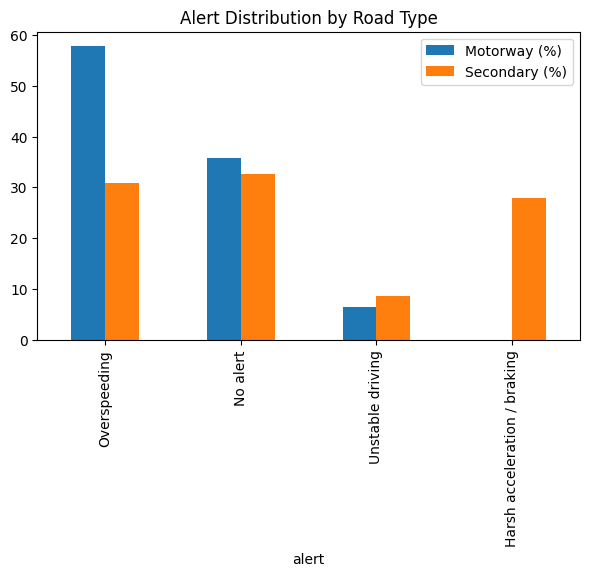

In [57]:
alert_comparison.plot(
    kind="bar",
    figsize=(7,4),
    title="Alert Distribution by Road Type"
)

The alert distribution aligns with real-world driving expectations, confirming that the KNN-based detection and clustering pipeline produces meaningful and context-aware driving risk alerts.

# NOW WE REACHED THE PERFORMANCE SCORING

### `“Given all detected behaviours, how risky is this driving profile?”`



We need a score that: increases when alerts increase, increases when alerts are severe and easy to explain

The clean formula we’ll use
Average severity × scaling factor

In [58]:
severity_map = {
    "No alert": 0,
    "Unstable driving": 1,
    "Harsh acceleration / braking": 2,
    "Overspeeding": 3
}

In [59]:
motor_df["severity"] = motor_df["alert"].map(severity_map)
secondary_df["severity"] = secondary_df["alert"].map(severity_map)

In [60]:
motor_avg_severity = motor_df["severity"].mean()
motor_avg_severity

np.float64(1.7981308411214953)

In [61]:
secondary_avg_severity = secondary_df["severity"].mean()
secondary_avg_severity

np.float64(1.5688073394495412)

Here we define the formula

In [62]:
def compute_session_performance(df, max_severity=3):
    avg_severity = df["severity"].mean()
    score = 100 - (avg_severity / max_severity) * 100
    return round(score, 2)

In [64]:
motor_score = compute_session_performance(motor_df)
secondary_score = compute_session_performance(secondary_df)

motor_score, secondary_score

(np.float64(40.06), np.float64(47.71))